In [1]:
# Import Libraries
import numpy as np

from project_utils.bb_model         import BB_Model
from project_utils.feature_stats    import Feature_Statistics_R
from project_utils.feature_stats    import Regression_Container
from project_utils.acq_data_capture import Acq_Data_nD
from project_utils.surroagte_gp     import Surrogate_GP



In [2]:
Num_Points    = 0
Title         = 'Synthetic Regression'
FUR_Weight    = 0.1
N_consistancy = 25
consist_bound = 0.3

In [3]:
if isinstance(FUR_Weight, float):
    FUR_Weight = [FUR_Weight, 1.0 - FUR_Weight]
    
print(FUR_Weight)

[0.1, 0.9]


In [4]:
Title = Title + ' W:'+ str(FUR_Weight)

In [5]:
# Load Forrester model

Reg_Data = BB_Model(dataset = 'Synthetic_Reg', Feature_Counts=[16,12])

#Reg_Data.df().head()

In [6]:
Reg_Data.MPL()

C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


0.661015213056186


MLPRegressor(random_state=RandomState(MT19937) at 0x244001D9840)

In [7]:
Reg_Data.Random_Forest()

0.6410245865616199


RandomForestRegressor(random_state=RandomState(MT19937) at 0x244001D9840)

In [8]:
Reg_Data.GP()

-0.3691180321040626


GaussianProcessRegressor()

In [9]:
Reg_Data.L_Regression()

0.7279032356115536


LinearRegression()

In [10]:
print(Reg_Data.get_features())

['Passive_0', 'Passive_1', 'Active_2', 'Active_3', 'Active_4', 'Active_5', 'Active_6', 'Active_7']


In [11]:
#Default settings
from unravel_2.ur_model import UR_Model

X_train, X_test, y_train, y_test = Reg_Data.get_TT_data()

#Initializing the explainer object
URM_Exp = UR_Model(bbox_model           = Reg_Data.get_Random_Forest(),
                   train_data           = X_train,
                   feature_names        = Reg_Data.get_features(),
                   categorical_features = Reg_Data.get_catagorical(),
                   mode                 = Reg_Data.get_mode(),
                   sampling_optimize    = "opt")

#sur_GP = Surrogate_GP()


In [12]:
#I2nd explainer object
URM_Exp_2 = UR_Model(bbox_model           = Reg_Data.get_L_Regression(),
                     train_data           = X_train,
                     feature_names        = Reg_Data.get_features(),
                     categorical_features = Reg_Data.get_catagorical(),
                     mode                 = Reg_Data.get_mode(),
                     sampling_optimize    = "opt")



In [13]:
mean = np.mean(X_train, axis=0)
std = np.std(X_train, axis=0)
print('Mean 0:', mean)
print('Std 0: ', std)


Mean 0: [ 16.15539705  18.88551637   8.90230024  17.15055943   7.9181673
  14.67597986 -11.37977574  12.71783154]
Std 0:  [2.51155377 1.27171788 5.07299076 4.55263416 3.02986222 5.08182164
 1.21119501 3.08625236]


In [14]:
# Generate explantion data for Random Forest

Reg_Stats   = Feature_Statistics_R(feature_names = Reg_Data.get_features(),
                                   mode          = Reg_Data.get_mode(),
                                   X_train_std   = Reg_Data.get_X_train_std(),
                                   N_consistancy = N_consistancy)

Reg_Stats_2 = Feature_Statistics_R(feature_names = Reg_Data.get_features(),
                                   mode          = Reg_Data.get_mode(),
                                   X_train_std   = Reg_Data.get_X_train_std())


if Num_Points > X_test.shape[0]: Num_Points = X_test.shape[0]

elif Num_Points == 0:            Num_Points = X_test.shape[0]

for test_instance in range(Num_Points):

    print('INSTANCE: ', test_instance)
       
    data_row  = np.array([X_test[test_instance]])
    
#    data_row  = np.array([0.4])

#    print('data row ',data_row)
    
    URM_Exp.explain(X_init      = data_row.reshape(1, -1),
                    Dimension   = 'Multi D',
                    kernel_type = "Matern",
                    max_iter    = 20,
                    alpha       = "FUR_W",
                    #jitter=5,
                    interval    = 1,
                    weight      = FUR_Weight,
                    normalize   = False)
       
    f_predict = Reg_Data.get_Random_Forest().predict(data_row.reshape(1, -1))

    e_predict = URM_Exp.exp_predict(data_row.reshape(1, -1))
    e_predict = np.array(e_predict).ravel()
    
    acq_data = URM_Exp.get_acq_data()
    
#    X, y = URM_Exp.get_surrogate_data()

#    e_predict = sur_GP.predict(X, y)
#    e_predict = sur_GP.predict(URM_Exp.get_surrogate_data())

    print(f_predict, e_predict, acq_data.get_fe_x0())
    
    scores = URM_Exp.permutation_importance()
    
    consistancy = URM_Exp.Y_Consistancy(N_points = N_consistancy, std_bound = consist_bound)
    
    URM_Exp.del_1_rel()
    
    del_1_var = URM_Exp.get_del_1_variance()
    
    Reg_Stats.Add_Sample(sample_scores = scores,
                         outcome       = y_test[test_instance],
                         X_row         = data_row.reshape(1, -1),
                         f_prediction  = f_predict,
                         e_prediction  = e_predict.ravel(),
                         feopt         = acq_data.get_fe_x0(),
                         consistancy   = consistancy,
                         del_1_var     = del_1_var)
    
    
    ############################################################################################
    
    URM_Exp_2.explain(X_init      = data_row.reshape(1, -1),
                      Dimension   = 'Multi D',
                      kernel_type = "Matern",
                      max_iter    = 20,
                      alpha       = "FUR_W",
                      #jitter=5,
                      interval    = 1,
                      weight      = FUR_Weight,
                      normalize   = False)
       
    f_predict = Reg_Data.get_L_Regression().predict(data_row.reshape(1, -1))

    e_predict = URM_Exp_2.exp_predict(data_row.reshape(1, -1))
    e_predict = np.array(e_predict).ravel()
    
    scores = URM_Exp_2.permutation_importance()
    
    Reg_Stats_2.Add_Sample(sample_scores = scores,
                           outcome       = y_test[test_instance],
                           X_row         = data_row.reshape(1, -1),
                           f_prediction  = f_predict,
                           e_prediction  = e_predict.ravel(),
                           feopt         = None)
    


INSTANCE:  0
Acq_Data_nD
[-65.55817996] [-6.55581800e+01  1.00000004e-05] [-65.55817998]
Acq_Data_nD


C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\_gpr.py:616: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\_gpr.py:616: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


INSTANCE:  1
Acq_Data_nD
[33.33303826] [3.33330383e+01 1.00000004e-05] [33.33303826]
Acq_Data_nD
INSTANCE:  2
Acq_Data_nD


C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\_gpr.py:616: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\_gpr.py:616: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


[-149.12093136] [-1.49120932e+02  1.00000004e-05] [-149.1209316]
Acq_Data_nD


C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\_gpr.py:616: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\_gpr.py:616: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\_gpr.py:616: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations

INSTANCE:  3
Acq_Data_nD
[43.2661585] [4.32661585e+01 1.00000004e-05] [43.26615849]
Acq_Data_nD


C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


INSTANCE:  4
Acq_Data_nD
Opt iteration fail:  ABNORMAL_TERMINATION_IN_LNSRCH
[-88.39393006] [-8.83939301e+01  1.00000004e-05] [-88.3939301]
Acq_Data_nD


In [15]:
import matplotlib.pyplot as plt


In [16]:
print(f_predict)
print(e_predict)


[-88.67397765]
[-8.86739777e+01  1.00000004e-05]


In [17]:
Reg_Stats.Feature_Counts(max_features=20, scaled=True, threshold=0.05)


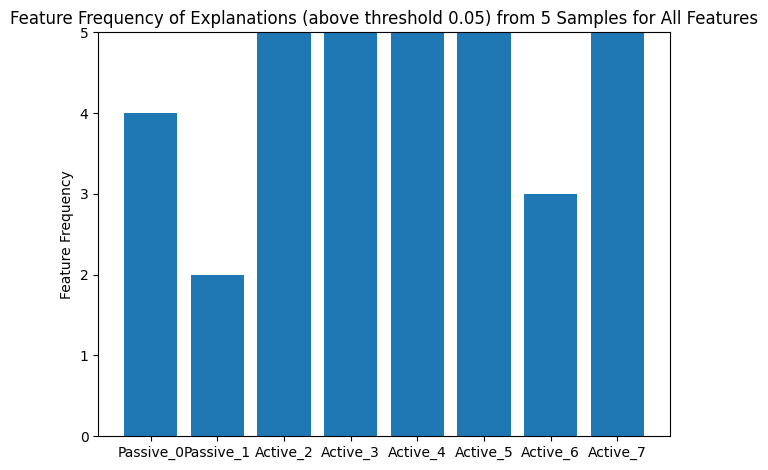

In [18]:
Reg_Stats.Frequency_Plot()


Average, SD, and Max Differences:
y - BB(x):           45.255487243253796  :  14.581152754579872  :  73.12106238172888
y - exp(x):          45.2554871933531  :  14.581152758251779  :  73.12106237703861
BB(x) - exp(x):      6.576242128630838e-08  :  9.643131693553964e-08  :  2.568622221588157e-07
Average exp(x) Uncertainty:  1.0000000413701846e-05
R Score:   1.0
Fidelity:  0.49256576915987266


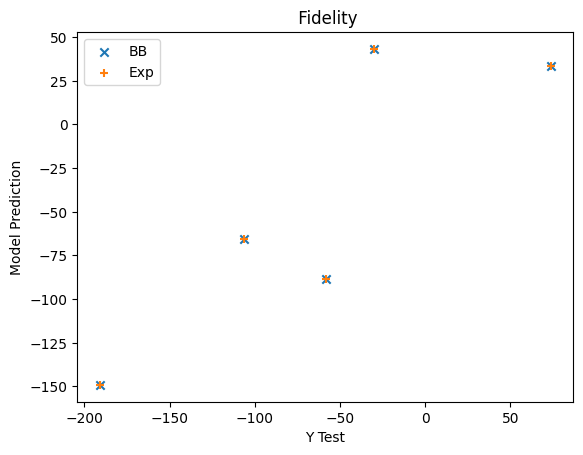

In [19]:
Reg_Stats.Fidelity()

In [20]:
Reg_Stats.Jaccard_Values()

Mean Jaccard Similarity:  0.7666666666666667
Mean Jaccard Distance:    0.23333333333333334


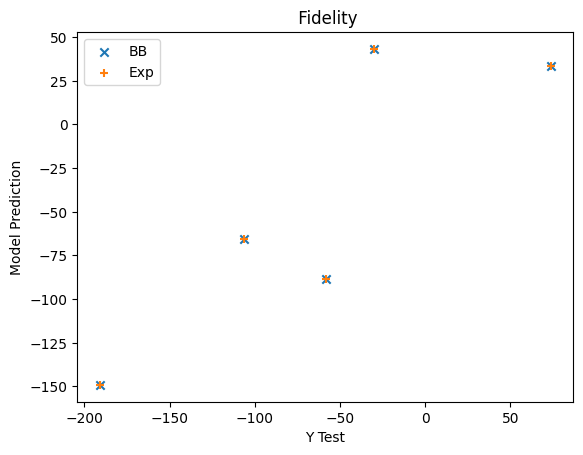

In [21]:
Reg_Stats.Reg_Fidelity_Graph()

top_features True
top_features (5, 8)


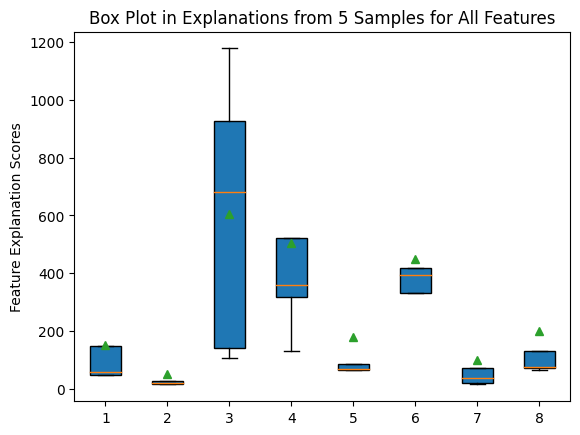

1 -      Passive_0
2 -      Passive_1
3 -      Active_2
4 -      Active_3
5 -      Active_4
6 -      Active_5
7 -      Active_6
8 -      Active_7


In [22]:
Reg_Stats.Box_Plot()


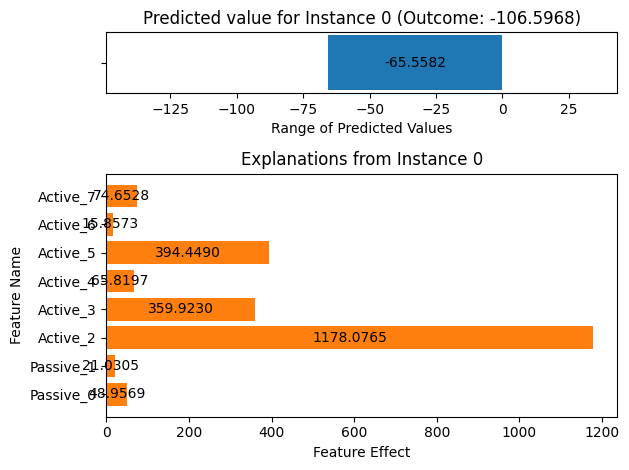

In [23]:
Reg_Stats.View_Explanation(instance = 0)

In [24]:
scores = URM_Exp.permutation_importance()
    
print(scores)

[ 70.44197853  17.40562872 110.27163999 286.87301104  87.18887061
 349.36631229  31.85499082  60.44106059]


In [25]:
scores_k = URM_Exp.KL_imp()

print(scores_k)

[ 5.97357199  4.46412806  3.68006707 10.15448381  5.78291527 10.75810209
  6.29369667  4.90635904]


In [26]:
scores_v = URM_Exp.Var_imp()

print(scores_v)

[23.92932328  6.79427117  7.21829064 65.40542282 22.49542244 67.48677662
 15.09754848 13.151475  ]


In [27]:
scores_d1 = URM_Exp.del_1_rel()

print(scores_d1)

[1.80406436e+00 1.89114224e+00 1.72227548e-03 1.68979142e+00
 1.97026240e-02 7.50526648e-01 1.00449043e+00 8.38560001e-01]


In [28]:
scores_d2 = URM_Exp.del_2_rel()

print(scores_d2)

[1.93811028 0.00825254 0.78823569 2.81427561 0.01009759 0.42096981
 0.76960236 1.25045611]


In [29]:
lin_scores = URM_Exp.Lin_scores()

print(lin_scores)

[-3.8175027  -1.75618548 -0.68442328 -7.51025274 -4.54013588  9.02075908
  5.10730242  3.62777732]


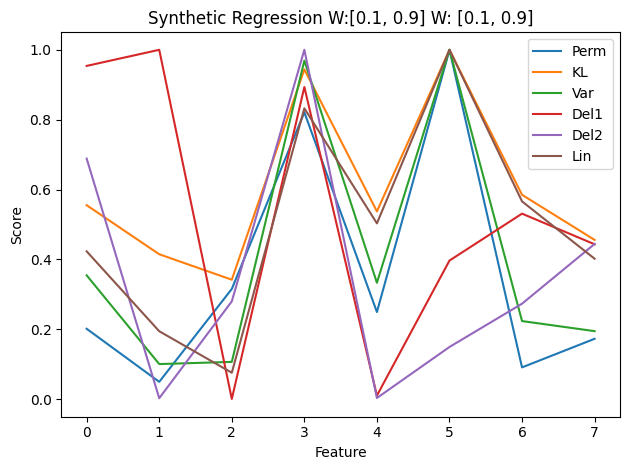

In [30]:
URM_Exp.plot_scores(Title, FUR_Weight)

In [31]:
print(URM_Exp.get_exp_L())


[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [ 6.16109429e-01  7.87660569e-01  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [ 9.26401585e-01  2.62229485e-01  2.70214360e-01  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.0

In [32]:
acq_data.Create_BB_plot()

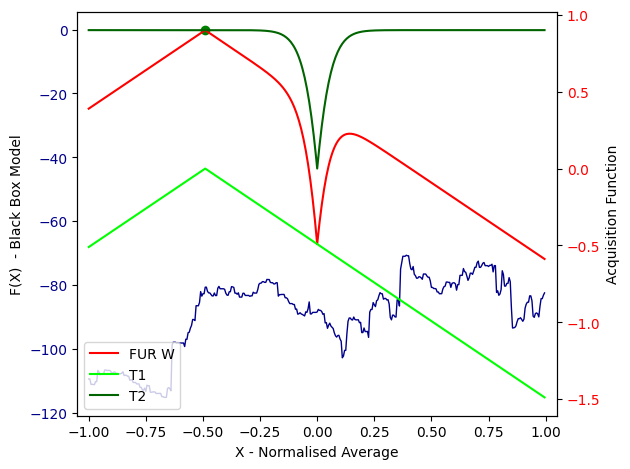

In [33]:
acq_data.plot_point(0)

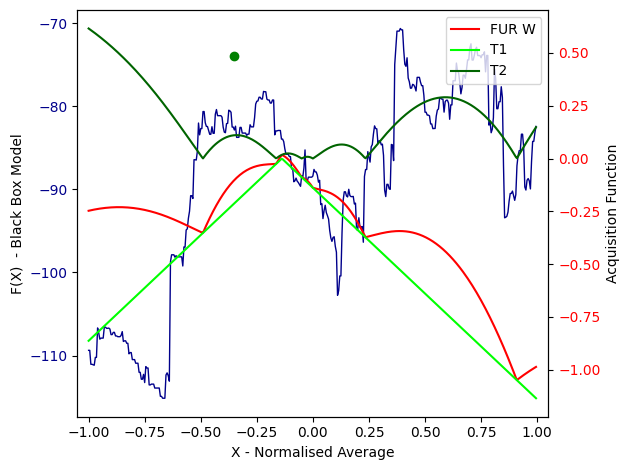

In [34]:
acq_data.plot_point(5)

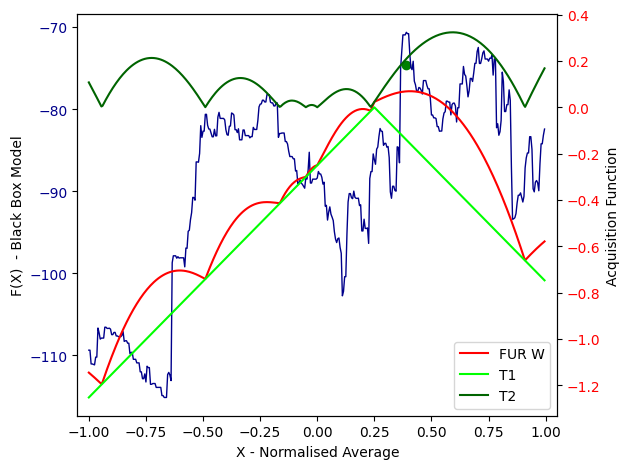

In [35]:
acq_data.plot_point(10)

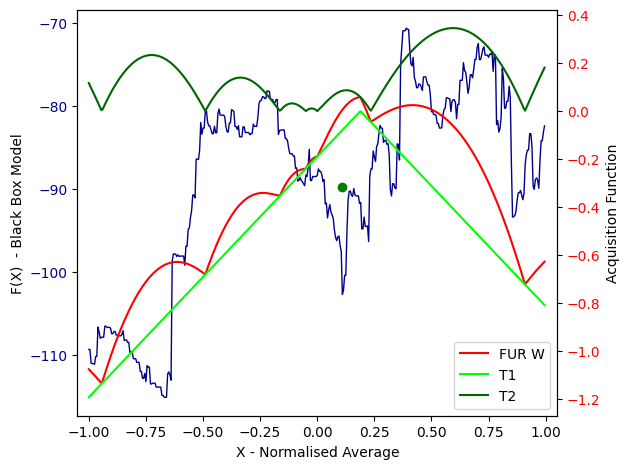

In [36]:
acq_data.plot_point(15)

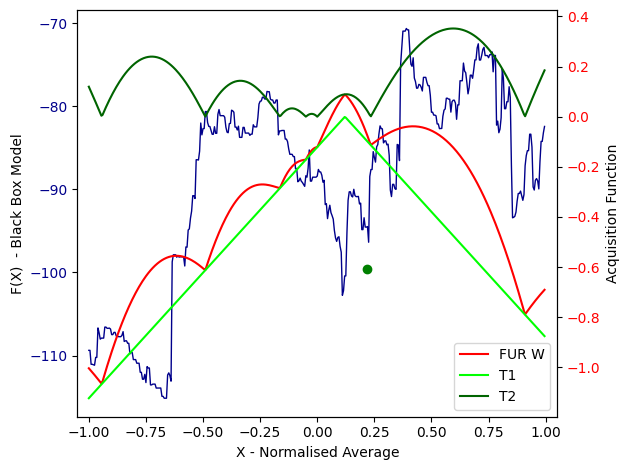

In [37]:
acq_data.plot_point(19)

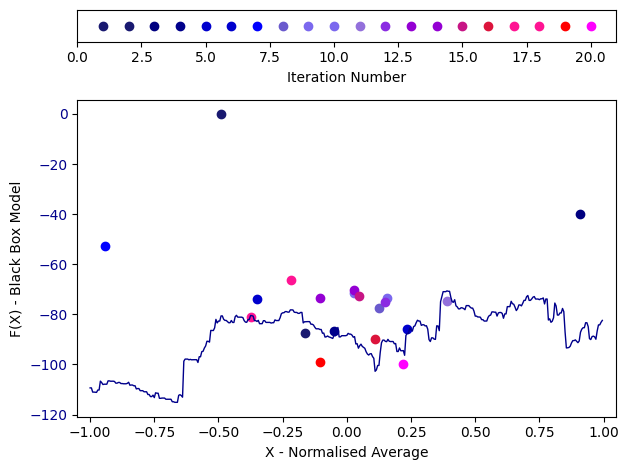

In [38]:
acq_data.plot_all()

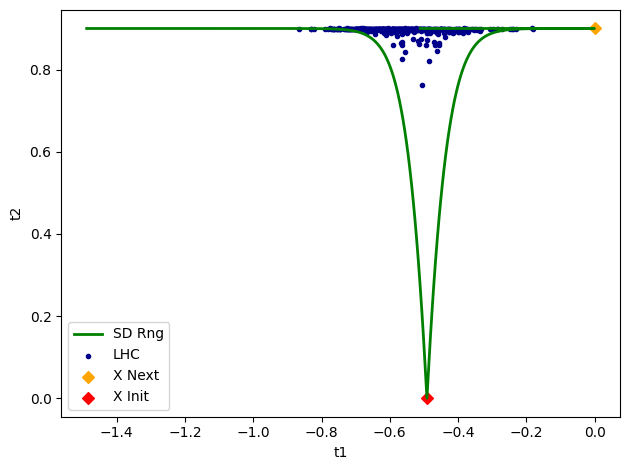

In [39]:
acq_data.plot_t1_t2(0)

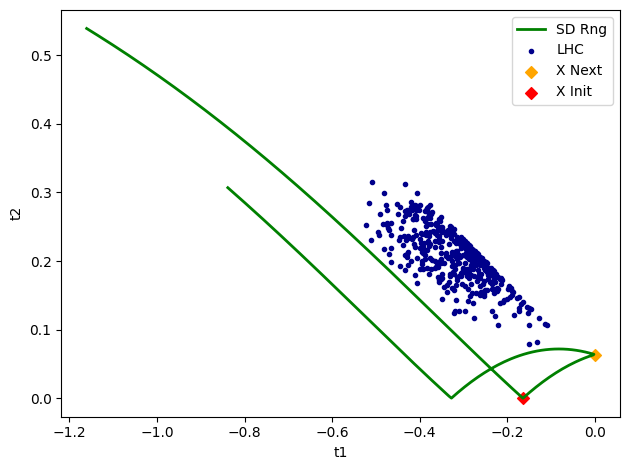

In [40]:
acq_data.plot_t1_t2(1)

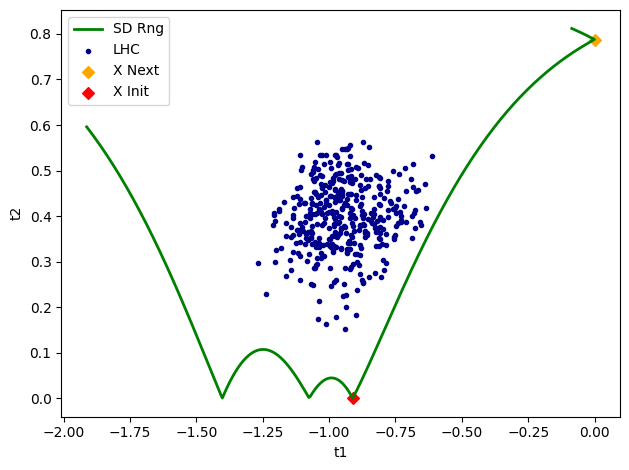

In [41]:
acq_data.plot_t1_t2(2)

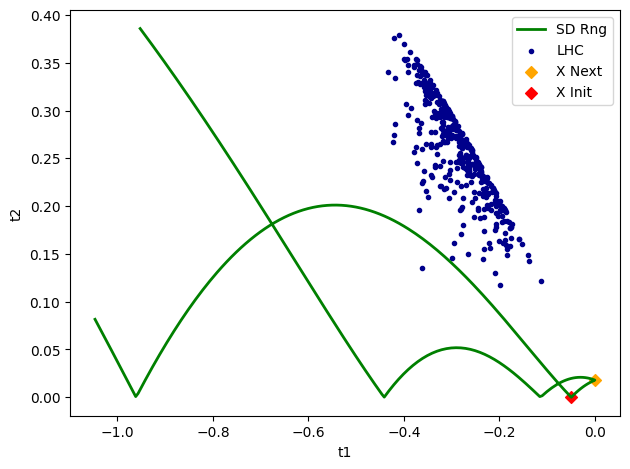

In [42]:
acq_data.plot_t1_t2(3)

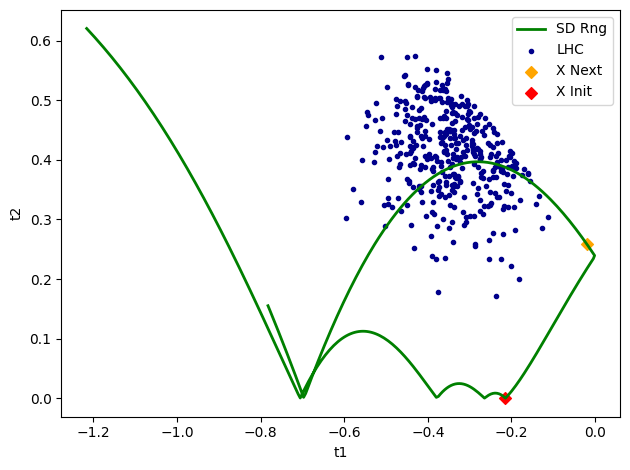

In [43]:
acq_data.plot_t1_t2(4)

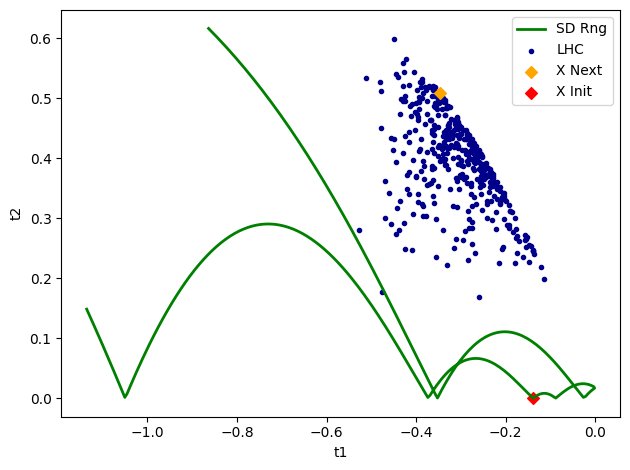

In [44]:
acq_data.plot_t1_t2(5)

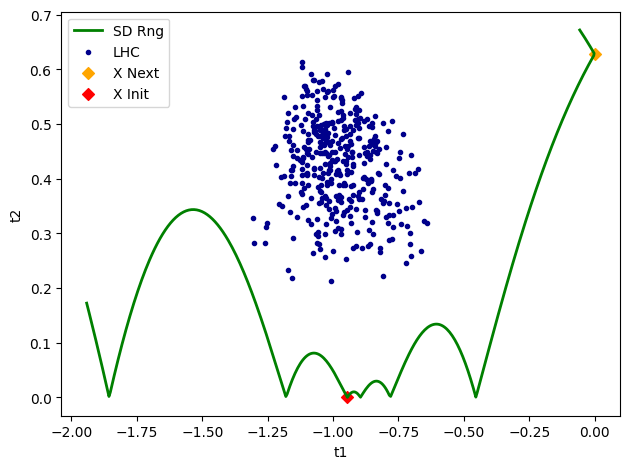

In [45]:
acq_data.plot_t1_t2(6)

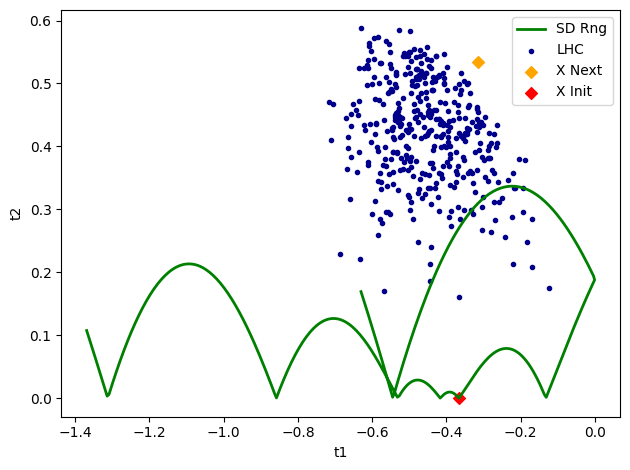

In [46]:
acq_data.plot_t1_t2(7)

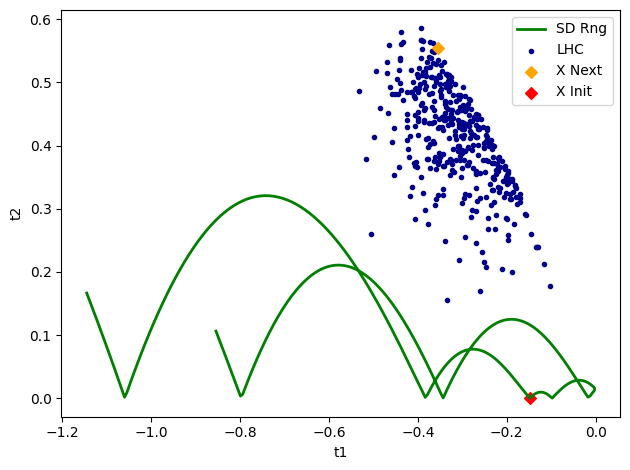

In [47]:
acq_data.plot_t1_t2(8)

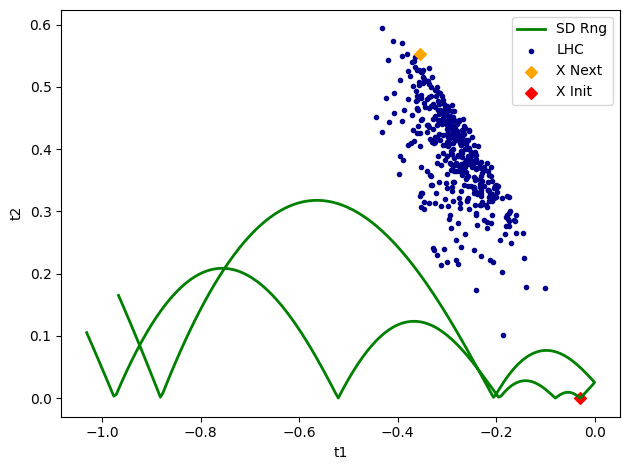

In [48]:
acq_data.plot_t1_t2(9)

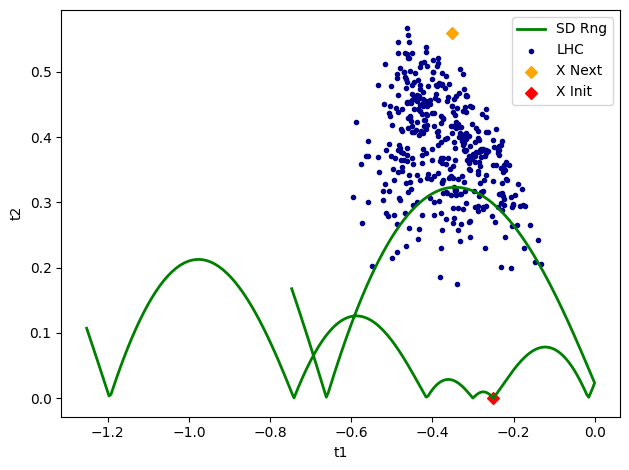

In [49]:
acq_data.plot_t1_t2(10)

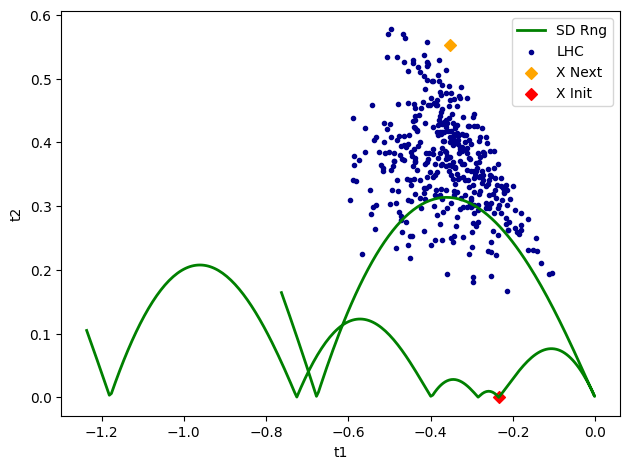

In [50]:
acq_data.plot_t1_t2(11)

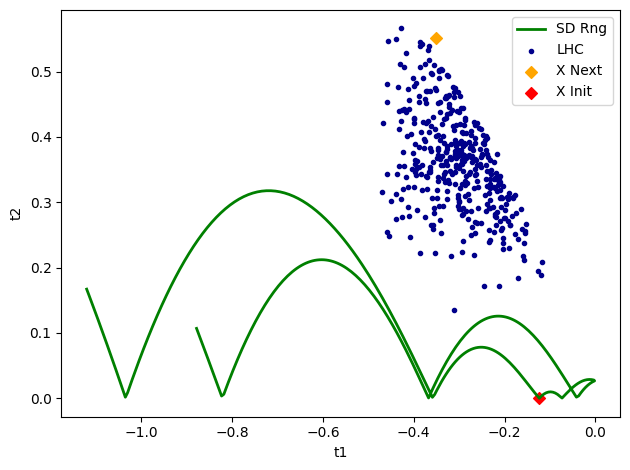

In [51]:
acq_data.plot_t1_t2(12)

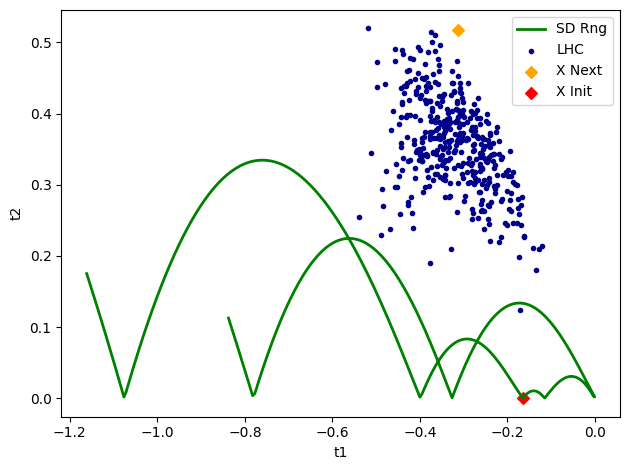

In [52]:
acq_data.plot_t1_t2(13)

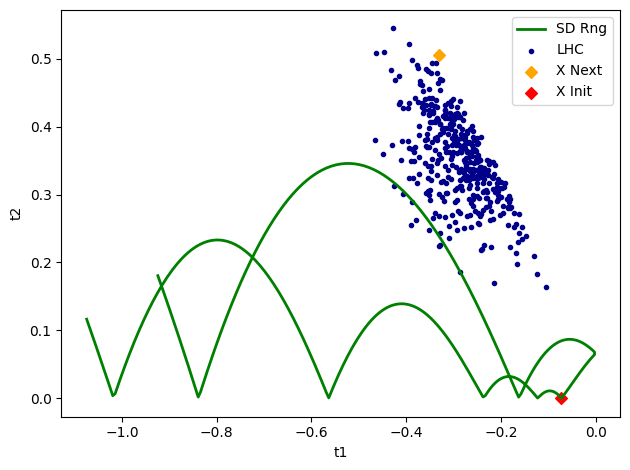

In [53]:
acq_data.plot_t1_t2(14)

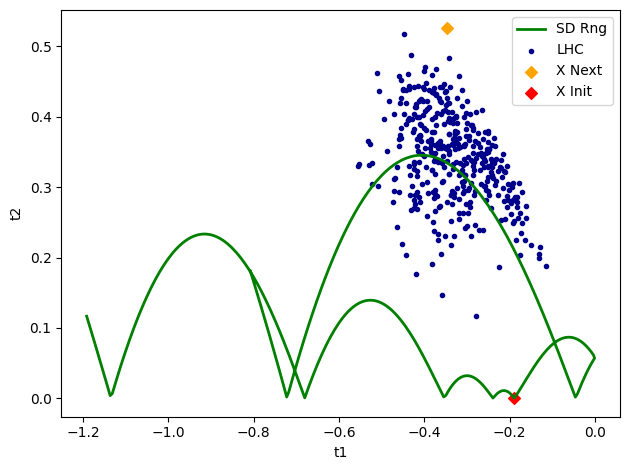

In [54]:
acq_data.plot_t1_t2(15)

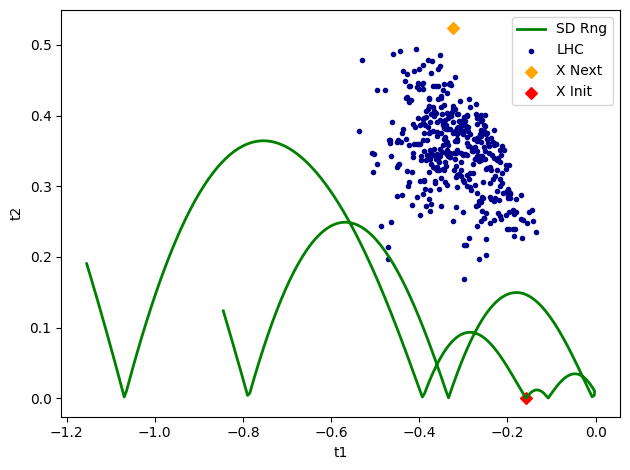

In [55]:
acq_data.plot_t1_t2(16)

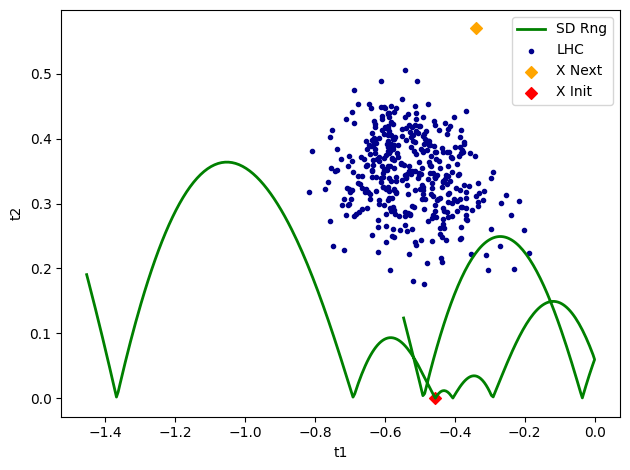

In [56]:
acq_data.plot_t1_t2(17)

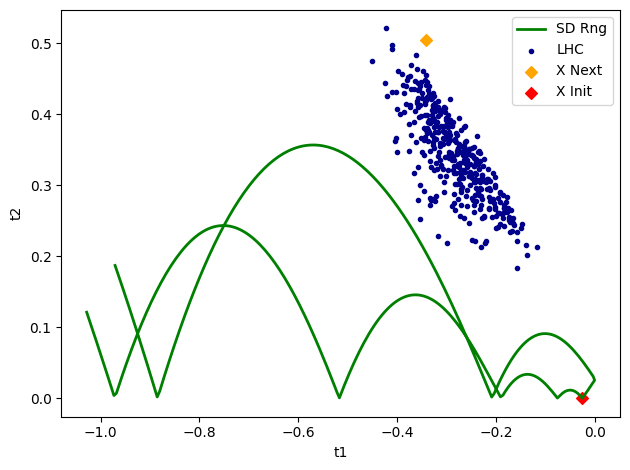

In [57]:
acq_data.plot_t1_t2(18)

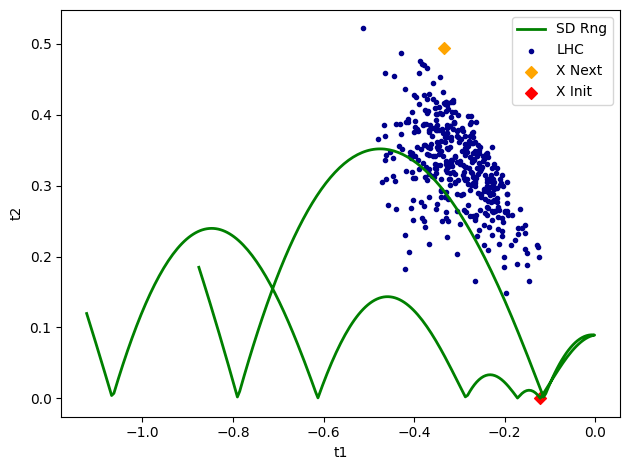

In [58]:
acq_data.plot_t1_t2(19)

Average, SD, and Max Differences:
y - BB(x):           45.255487243253796  :  14.581152754579872  :  73.12106238172888
y - exp(x):          45.2554871933531  :  14.581152758251779  :  73.12106237703861
BB(x) - exp(x):      6.576242128630838e-08  :  9.643131693553964e-08  :  2.568622221588157e-07
Average exp(x) Uncertainty:  1.0000000413701846e-05
R Score:   1.0
Fidelity:  0.49256576915987266


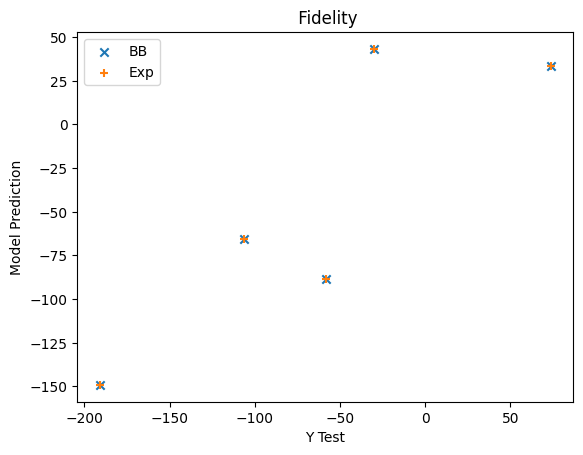

Fidelity:  0.49256576915987266


In [59]:
Reg_Stats.Fidelity()

print('Fidelity: ', Reg_Stats.fidelity)

In [60]:
Reg_Stats.Jaccard_Values(top_k=4)

print('Jaccard: ', Reg_Stats.jaccard_similarities)

Mean Jaccard Similarity:  0.6399999999999999
Mean Jaccard Distance:    0.36
Jaccard:  0.6399999999999999


In [61]:
Reg_Stats.add_Feature_Coeffs(Feature_Coeffs = Reg_Data.get_Feature_Coeffs())
        
print('Coeff Ratio: ', Reg_Stats.coeffs_ratio)

Mean Coeffs Ratio:  [ 0.          0.          2.68253268 -5.20330723 -7.01591534  7.23773212
 19.35614376 -3.30437645]
Mean Coeffs Error:  5.850000946123854
Feature Coeff Correlation:  [[1.         0.11954387]
 [0.11954387 1.        ]]
Coeff Ratio:  [ 0.          0.          2.68253268 -5.20330723 -7.01591534  7.23773212
 19.35614376 -3.30437645]


In [62]:
delete_1_var = Reg_Stats.delete_one()

print('Delete 1 Variance: ', delete_1_var)

mean_variance [6519.33539992 6855.49583773 3186.24137024 6235.82401944 3048.28753395
 2693.89264046 3950.22448608 4845.67043153]
Mean scores: [6519.33539992 6855.49583773 3186.24137024 6235.82401944 3048.28753395
 2693.89264046 3950.22448608 4845.67043153]
sort_order [1 6 0 4 7 5 3 2]
sorted_scores [0.17848576 0.35200203 0.54100788 0.64422018 0.71680177 1.60460389
 1.79679896 2.16607954]
sorted_variance [1.46897036 0.84643953 1.39693914 0.65317581 1.03831238 0.57723738
 1.33618937 0.68273605]
Prediction Variance Feature Deletion: [6519.33539992 6855.49583773 3186.24137024 6235.82401944 3048.28753395
 2693.89264046 3950.22448608 4845.67043153]
Delete One Incoherence: 0.7428299023371202
Delete 1 Variance:  None


N_Points:  25


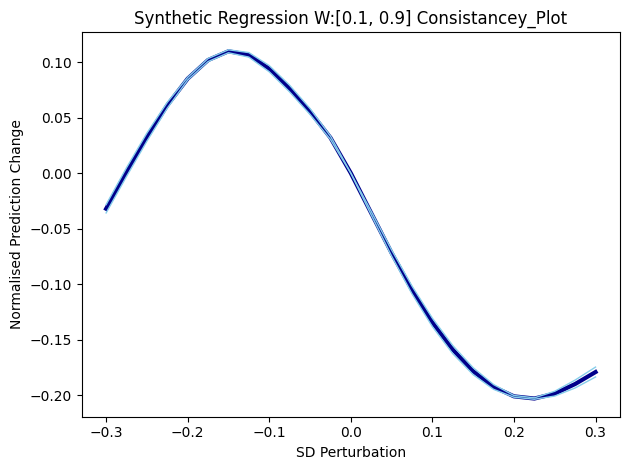

In [63]:
Reg_Stats.Consistancy(std_bound = consist_bound, plot=True, title = Title)

In [64]:
Reg_Stats.Compare_Models (model_b = Reg_Stats_2)

Score Diff Mean:  [0.62767177 0.20565064 2.35851495 1.9996566  0.71912943 0.89073341
 0.39021577 0.80842742]
Score Diff SD:    [0.6663024  0.23938865 2.50088836 1.81377507 1.01925691 2.04992479
 0.60040589 1.01209553]


C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\lib\function_base.py:2845: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\lib\function_base.py:2704: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\lib\function_base.py:2704: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


MARD:  None
Feature Correlation:  [[nan nan]
 [nan nan]]


Calibration MSE/MAE 0.7318309804548846 0.5333651626555891


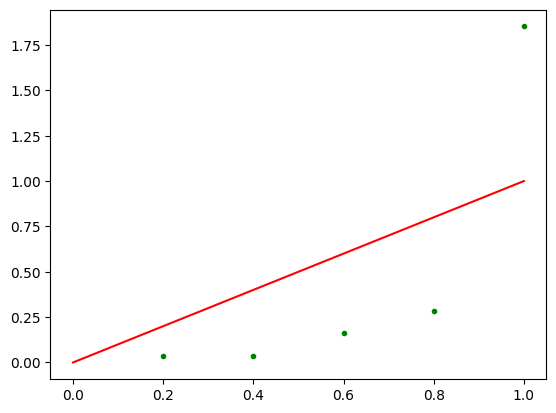

In [65]:
Reg_Stats.Regression_Calibration(plot=True, title=Title)

In [66]:
print(Reg_Stats.calibration_MAE)

0.5333651626555891


In [70]:
Reg_Stats.Regression_Calibration_2(plot=True, title=Title)

root_mean_squared_calibration_error:  0.5638599534796269


In [68]:
Reg_Stats.delete_one()

mean_variance [6519.33539992 6855.49583773 3186.24137024 6235.82401944 3048.28753395
 2693.89264046 3950.22448608 4845.67043153]
Mean scores: [6519.33539992 6855.49583773 3186.24137024 6235.82401944 3048.28753395
 2693.89264046 3950.22448608 4845.67043153]
sort_order [1 6 0 4 7 5 3 2]
sorted_scores [0.17848576 0.35200203 0.54100788 0.64422018 0.71680177 1.60460389
 1.79679896 2.16607954]
sorted_variance [1.46897036 0.84643953 1.39693914 0.65317581 1.03831238 0.57723738
 1.33618937 0.68273605]
Prediction Variance Feature Deletion: [6519.33539992 6855.49583773 3186.24137024 6235.82401944 3048.28753395
 2693.89264046 3950.22448608 4845.67043153]
Delete One Incoherence: 0.7428299023371202


In [69]:
Reg_Stats.Results_Summary(Title)

Results_Summary: Synthetic Regression W:[0.1, 0.9]
R Score:   1.0
Fidelity:  0.49256576915987266
Consistancey Std/Y Pert:  0.3 : -0.10564919844633407
Delete One Incoherence:   0.7428299023371202
Mean Jaccard Similarity:  0.6399999999999999
Mean Jaccard Distance:    0.36
Calibration MSE/MAE:  0.7318309804548846 : 0.5333651626555891
Score Diff Mean:  [0.62767177 0.20565064 2.35851495 1.9996566  0.71912943 0.89073341
 0.39021577 0.80842742]
Score Diff SD:    [0.6663024  0.23938865 2.50088836 1.81377507 1.01925691 2.04992479
 0.60040589 1.01209553]
Mean Coeffs Error:  5.850000946123854
